In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
from utiles import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from imblearn.over_sampling import ADASYN

## Loading Data

In [2]:
loader = DataHandler("data")
loader.load_all()
data = loader.get_all()

## Preprocessing Data

In [3]:
loader.datos.keys()

dict_keys(['sudan 4 - 5%', 'sudan 4 - 2,5%', 'sudan 2 - 2,5%', 'sudan 4 - 1%', 'sudan 1 - 5%', 'sudan 2 - 1%', 'sudan 1 - 2,5%', 'sudan 2 - 5%', 'sin adulterar', 'para red - 5%', 'sudan 3 - 5%', 'para red - 1%', 'sudan 1 - 1%', 'para red - 2,5%'])

In [4]:
clase = "sudan 4 - 2,5%"
target = np.where(data["clase"] == clase, 0, 1)
np.bincount(target)

array([ 40, 526])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], target)

ad = ADASYN(ratio="minority", random_state=15, n_jobs=4)
new_X_train, new_y_train = ad.fit_sample(X_train, y_train)
np.bincount(y_train), np.bincount(new_y_train)

(array([ 30, 394]), array([401, 394]))

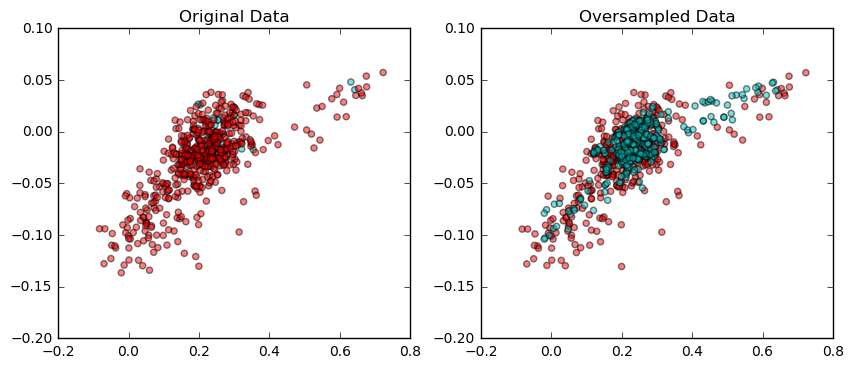

In [6]:
c = np.array(["c","r"])
fig, (ax) = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(data.iloc[:,0], data.iloc[:,-3], c=c[target], alpha=.5)
ax[0].set_title("Original Data")
ax[1].scatter(new_X_train[:,0], new_X_train[:,-3], c=c[new_y_train], alpha=.5)
ax[1].set_title("Oversampled Data")
plt.show()

In [7]:
std = StandardScaler()
scaled_X_train = std.fit_transform(new_X_train)
scaled_X_test = std.transform(X_test)

scaled_ = std.transform(data.iloc[:,:-1])

model = LogisticRegression()                # create the RFE model and select 20 from 1557 attributes
rfe = RFE(model, 20, step=20)
rfe = rfe.fit(scaled_X_train, new_y_train)

indices = np.where(rfe.support_)            # Mask of selected features

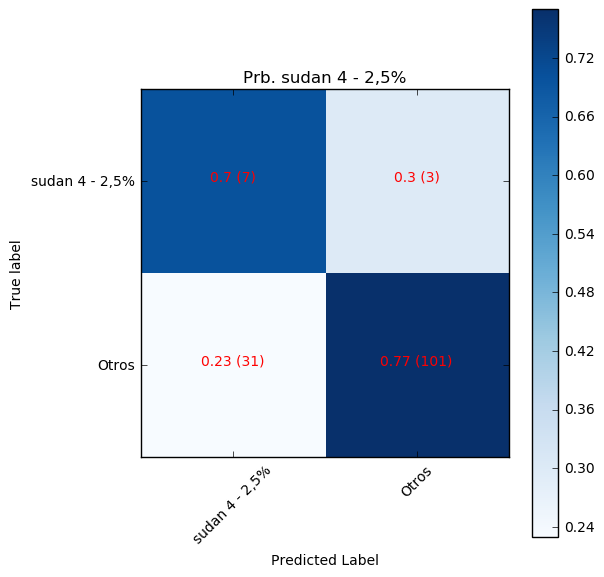

[ 0.94444444  0.96418733  0.96132597]
C-K value: 0.202774108322325


In [14]:
# clf = RandomForestClassifier(**par["params"])
# clf.n_jobs = 4
clf = RandomForestClassifier(max_depth=8, n_jobs=4, n_estimators=40, criterion="entropy",
                             max_features="auto", class_weight={0:.5, 1:1})
clf.fit(scaled_X_train[:, indices[0]], new_y_train)

predicted = clf.predict( scaled_X_test[:, indices[0]] )

cm = confusion_matrix(y_pred=predicted, y_true=y_test)
plot_confusion_matrix(classes=[clase, "Otros"], cm=cm, norm=True, title="Prb. {}".format(clase), size=(6, 6))
kappa_ = make_scorer(cohen_kappa_score)

val = cross_val_score(estimator=clf, X=scaled_[:, indices[0]], y=target, n_jobs=4, scoring="f1", cv=3)
print(val)
print("C-K value: {}".format(cohen_kappa_score(y_test, predicted)))

In [9]:
scaled_X_train.shape[0] / (2 * np.bincount(new_y_train))

array([ 0.99127182,  1.00888325])

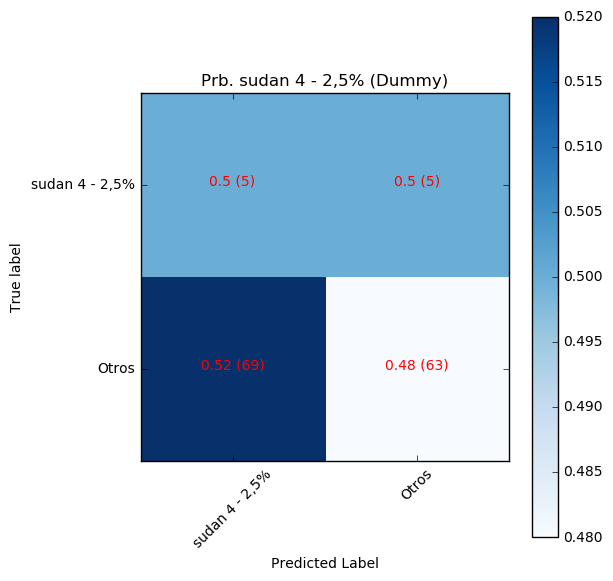

[ 0.62453532  0.64179104  0.64179104]
C-K value: -0.005742725880551358


In [10]:
from sklearn.dummy import DummyClassifier

d_clf = DummyClassifier(strategy="uniform")
d_clf.fit(scaled_X_train[:, indices[0]], new_y_train)

d_predicted = d_clf.predict( scaled_X_test[:, indices[0]] )

d_cm = confusion_matrix(y_pred=d_predicted, y_true=y_test)
plot_confusion_matrix(classes=[clase, "Otros"], cm=d_cm, norm=True, title="Prb. {} (Dummy)".format(clase), size=(6, 6))
kappa_ = make_scorer(cohen_kappa_score)

val = cross_val_score(estimator=d_clf, X=scaled_[:, indices[0]], y=target, n_jobs=4, scoring="f1", cv=3)
print(val)
print("C-K value: {}".format(cohen_kappa_score(y_test, d_predicted)))